1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import PIL

In [3]:
# relatively guided, straightforward.
# "Q, quantile" is the number (function of p) st the prob of the random variable being less or eq to Q is equal to p
# so instead of fitting a gaussian (binned wind speed on x axis and occurences, probabilities if normalised,  on y axis),
# we fit Q(p) = sqrt(2) erf^-1(2p-1) as per Wikipedia (or rather a generic function?); 
# where p(x_i), after arranging dataset in ascending order, is the fraction of measures less or equal to x_i 
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
cprob=np.array([(i+1)/(years_nb+1) for i in range(years_nb)])
max_speeds_sorted=np.sort(max_speeds)
quantile_func=sp.interpolate.make_splrep(y=max_speeds, x=cprob)
fifty_prob=1.-0.02
fifty_wind=quantile_func(fifty_prob)
print(max_speeds)
print(fifty_wind)
# ---> double check? evm plot?

[28.09 22.46 26.65 26.65 28.79 30.19 26.19 26.75 23.34 24.16 29.75 27.93
 26.68 23.85 32.97 25.79 26.37 25.28 26.73 23.2  26.76]
38.81546784375299


2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celsius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.

* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

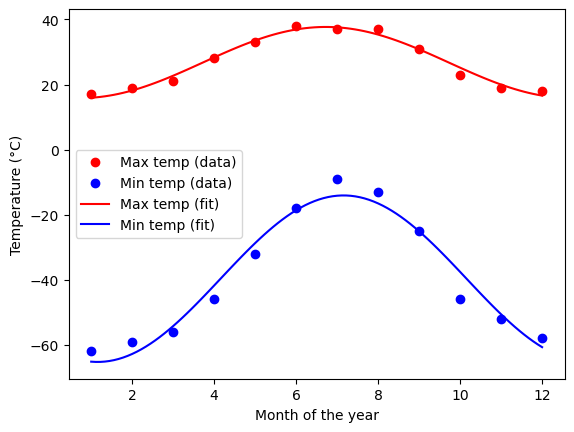

Difference in offset parameter: 12.977 days


In [4]:
#1- use pyplot;
#2/5- as daylight is a sine function of time of the year (and latitude and possibly longitude),
# makes sense to use it to fit eg the max temperatures
# also should use two of them, as it's clear that thermal excursion is not constant;
# so the function for min temperature should have the same 12-month periodicity bud include a phase (-> diff maxs and mins)
max_temps=np.array([17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
min_temps=np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
fig,ax = plt.subplots()
months=np.arange(1,13)
ax.plot(months, max_temps, 'o', label="Max temp (data)", color='r')
ax.plot(months, min_temps, 'o', label="Min temp (data)", color='b')
ax.set_xlabel("Month of the year")
ax.set_ylabel("Temperature (°C)")

omega=np.pi / 6
def fitfunc(x, a, phi, b):
    return a*np.sin(omega*x+phi)+b
opt_pars_max, pars_covariance_max = sp.optimize.curve_fit(fitfunc, months, max_temps)
lin=np.linspace(1,12, 100)
ax.plot(lin, fitfunc(lin, opt_pars_max[0], opt_pars_max[1], opt_pars_max[2]),
        label="Max temp (fit)", color='r')
opt_pars_min, pars_covariance_min = sp.optimize.curve_fit(fitfunc, months, min_temps)
ax.plot(lin, fitfunc(lin, opt_pars_min[0], opt_pars_min[1], opt_pars_min[2]),
        label="Min temp (fit)", color='b')
plt.legend(loc='best')
plt.show()

# ---> pretty good, but min temps are asymmetric

time_offsets=np.array([opt_pars_max[1], opt_pars_min[1]])*(6/np.pi)
time_off_diff=np.abs(time_offsets[0]-time_offsets[1])
time_off_diff=min(time_off_diff, (6-time_off_diff))*30
print(f"Difference in offset parameter: {time_off_diff:.3f} days") 
# ---> about the same

3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


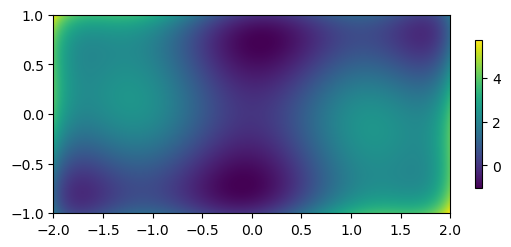

In [5]:
def f(x:np.ndarray):
    value=(4 - 2.1*(x[0]**2) + (x[0]**4)/3)*(x[0]**2) + (x[0]*x[1]) +(4*(x[1]**2)-4)*(x[1]**2)
    return value
x_dom=np.linspace(-2,2,1000)
y_dom=np.linspace(-1,1,1000)

X=np.meshgrid(x_dom,y_dom) 
# ---> NB the args
#print(f(X))
plt.imshow(f(X), extent=[-2, 2, -1, 1]) 
plt.colorbar(shrink=0.4)
plt.show()
# ---> TODO: add labels/title?

In [6]:
# also "by hand" draw multiple intervals and use Brent optimization over each and then argmin?
x0 = [0,-1]
x1 = [0,1]
origin =[0,0]
solution0 = sp.optimize.basinhopping(f, x0, stepsize=0.2) 
solution1 = sp.optimize.basinhopping(f, x1, stepsize=0.2) 
solution_origin = sp.optimize.basinhopping(f, origin, stepsize=0.2) 
print(solution0.x, solution0.fun, solution1.x, solution1.fun, solution_origin.x)
# ---> as two global minima, set [max] stepsize smaller than separation (in argument) between them.
#      found that 0.2 guarantees finding both, 0.3 or higher not always

[ 0.08984201 -0.71265641] -1.031628453489877 [-0.08984202  0.7126564 ] -1.0316284534898772 [-0.08984201  0.7126564 ]


4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

In [7]:
# use fFT, very much the same procedures as last part of notes
! wget https://www.dropbox.com/s/3vigxoqayo389uc/populations.txt -P C:\Users\Libero\LaboratoryOfComputationalPhysics_Y8\data\

--2026-01-17 19:20:22--  https://www.dropbox.com/s/3vigxoqayo389uc/populations.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/qnkkslc4wt15bziu8c8do/populations.txt?rlkey=mxkget6g834glvegmf12yl2op [following]
--2026-01-17 19:20:23--  https://www.dropbox.com/scl/fi/qnkkslc4wt15bziu8c8do/populations.txt?rlkey=mxkget6g834glvegmf12yl2op
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4e1b31241734cf33b0271f0ac0.dl.dropboxusercontent.com/cd/0/inline/C5KdvCQmAuSC29-UbixQ2oel3BcnNao6K4E93VZuBehx0_xpD0ky7ZZLRuU29nF_bY2zAceKu31njIrdMreRcq1MfjZgY-NET0EYMripmuFRifPmFpTKE_BeohIbZJjotxs/file# [following]
--2026-01-17 19:20:23--  https://uc4e1b31241734cf33b0271f0ac0.dl.dropboxusercontent.com/cd/0/inline/C5KdvCQmAuSC29-UbixQ2oel3BcnNao6K4E93VZ

         hare     lynx  carrot
year                          
1900  30000.0   4000.0   48300
1901  47200.0   6100.0   48200
1902  70200.0   9800.0   41500
1903  77400.0  35200.0   38200
1904  36300.0  59400.0   40600 Index([1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911,
       1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920],
      dtype='int64', name='year') Index(['hare', 'lynx', 'carrot'], dtype='object')


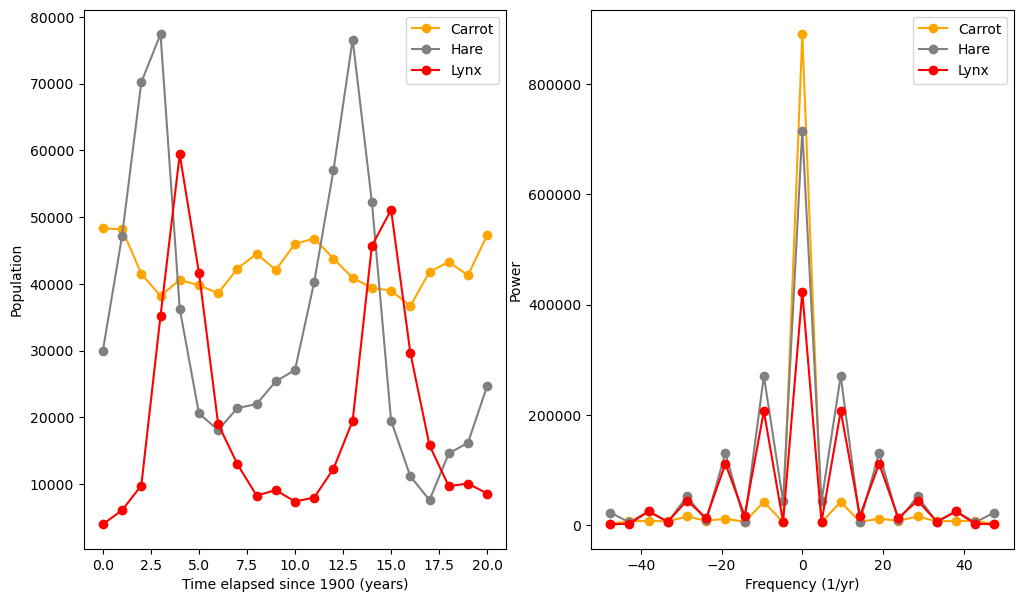

In [178]:
filename=r"C:\Users\Libero\LaboratoryOfComputationalPhysics_Y8\data\populations.txt"
with open(filename, 'r') as f:
    first_line = f.readline().strip('#') # ---> NB this (to assign the variable "headers")
    headers = first_line.split()
df = pd.read_csv(filename, sep="\t", skiprows=1, names=headers, index_col=0)
print(df.head(), df.index, df.columns)
fig, (ax1,ax2)=plt.subplots(1,2, figsize=(12,7))
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True)) # ---> doesnt work, why?
N=len(df)
time_step=0.01 #---> ?
timeseries=np.arange(N)
ax1.plot(timeseries, df['carrot'], 'o-', label="Carrot", color='orange')
ax1.plot(timeseries, df['hare'], 'o-', label="Hare", color='grey')
ax1.plot(timeseries, df['lynx'], 'o-', label="Lynx", color='red')
ax1.set_xlabel("Time elapsed since 1900 (years)")
ax1.set_ylabel("Population")
# ---> TODO: review what it does exactly (in terms of arrays especially)?
carrot_fft=sp.fft.fft(np.asarray(df['carrot']))
#print(carrot_fft.shape)
carrot_power=np.abs(carrot_fft)
carrot_freq = sp.fft.fftfreq(N, d=time_step)
carrot_idx=np.argsort(carrot_freq) # ---> NB this
ax2.plot(carrot_freq[carrot_idx], carrot_power[carrot_idx], 'o-', label="Carrot",color='orange')
hare_fft=sp.fft.fft(np.asarray(df['hare']))
hare_power=np.abs(hare_fft)
hare_freq = sp.fft.fftfreq(N, d=time_step)
hare_idx=np.argsort(hare_freq) 
ax2.plot(hare_freq[hare_idx], hare_power[hare_idx], 'o-', label="Hare",color='grey')
lynx_fft=sp.fft.fft(np.asarray(df['lynx']))
lynx_power=np.abs(lynx_fft)
lynx_freq = sp.fft.fftfreq(N, d=time_step)
lynx_idx=np.argsort(lynx_freq) 
ax2.plot(lynx_freq[lynx_idx], lynx_power[lynx_idx], 'o-', label="Lynx",color='red')

ax2.set_xlabel("Frequency (1/yr)")
ax2.set_ylabel("Power")

ax1.legend()
ax2.legend()
plt.show()
# ---> TODO: fix axes ticks, spacing between ax1 and ax2

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fft, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

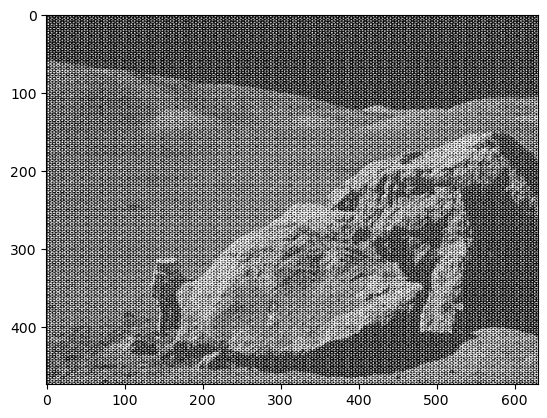

In [110]:
#1/3- 2d Fourier transform are pretty obviously defined (see Wiki),
# however it will be a function of two variables (two "frequencies")
#5- ie plot the function as a truncated Fourier expansion
img=PIL.Image.open(".\moonlanding.png")
plt.imshow(img, cmap='gray', vmin=0, vmax=255)

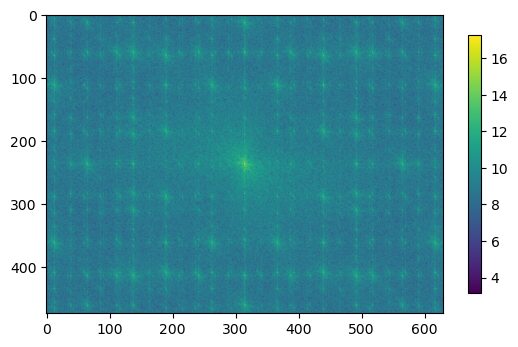

In [93]:
# ---> NB by default "zero" frequency is at top left corner (fftshift to move it to center) :
img_fft=sp.fft.fftshift(sp.fft.fft2(img)) 
#print(img_fft.shape, img_fft)
img_power=np.abs(img_fft)
plt.imshow(np.log(img_power)) # ---> NB this (too large changes)
plt.colorbar(shrink=0.7)
plt.show()
# ---> TODO: add labels/title?

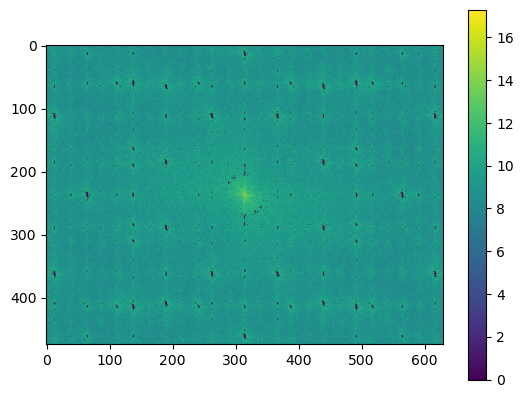

In [174]:
thresh = np.percentile(img_power, 99) # ---> NB this
filtered_img_fft=img_fft.copy()
#print(filtered_freq_fft.shape)
mask = np.abs(filtered_img_fft) > thresh

# ---> NB this to keep central component (real information):
center = (filtered_img_fft.shape[0]//2, filtered_img_fft.shape[1]//2)
x, y = np.ogrid[:filtered_img_fft.shape[0], :filtered_img_fft.shape[1]]
# ---> TODO: review what it does exactly (in terms of arrays especially) - or, simply try a "square" inner mask?
radius = 30  
circle_mask = (y - center[1])**2 + (x - center[0])**2 <= radius**2
mask[circle_mask] = False 
filtered_img_fft[mask]=0

filtered_image=sp.fft.ifft2(sp.fft.ifftshift(filtered_img_fft))
filtered_img_fft_power=np.abs(filtered_img_fft)
plt.imshow(np.log(filtered_img_fft_power+1)) # ---> NB +1 to avoid log(0)
plt.colorbar()
# ---> TODO: add labels/title?

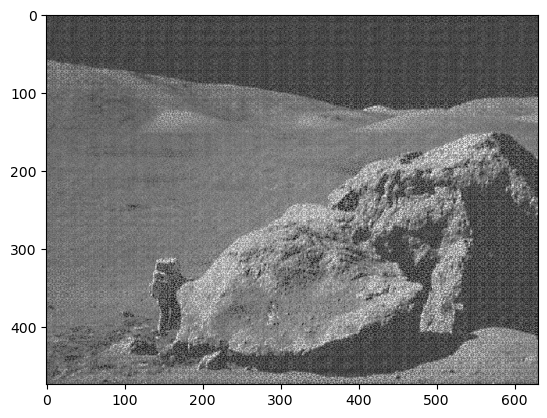

In [175]:
plt.imshow(np.real(filtered_image),cmap='gray', vmin=0, vmax=255)
# ---> TODO: try better parameters